**Write the names of all group members (max. 5 members)**:
- Lucas, Gimeno
- Nils, Johnson
- Hai Yen, Van
- Matteo, Bodmer
- Jonas, Isler

When submitting your work, please follow closely the template below.

# Exercise 1 (Poisson GLM)

### Question 1.a

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_poisson_deviance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# Detect device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {DEVICE}")

[INFO] Using device: cuda


In [2]:
# Set random seeds for reproducibility
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    # Additional settings for deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"Random seeds set to {SEED} for reproducibility")

Random seeds set to 42 for reproducibility


In [3]:
# Read csv file `freMTPL2freq.csv` (e.g. use pandas)
# Use semicolon separator and comma decimal (common for this dataset)
dataframe = pd.read_csv('freMTPL2freq.csv', sep=';', decimal=',', encoding='utf-8')
print(dataframe.head())
# extracrt features X and target y from the dataframe
X_full = dataframe[["VehPower", "VehAge", "DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"]]
y_full = dataframe[["Exposure", "ClaimNb"]]
y_full["ClaimFrequency"] = y_full["ClaimNb"]/y_full["Exposure"]
# print data sizes
print(f'head of X (full dataset) is {X_full.head()} with sieze {X_full.shape}')
print(f'head of y (full dataset) is {y_full.head()} with sieze {y_full.shape}')

   VehPower  VehAge  DrivAge  BonusMalus VehBrand   VehGas  Density Region  \
0         4       9       23         100       B6  Regular     7887    R31   
1         4       6       26         100       B6  Regular     2308    R31   
2         4       6       26         100       B6  Regular     2308    R31   
3         7       4       44          50       B6  Regular       37    R94   
4         5       2       29          90       B6  Regular      335    R91   

   Exposure  ClaimNb  
0      0.76        0  
1      0.74        0  
2      0.11        0  
3      0.83        0  
4      0.69        0  
head of X (full dataset) is    VehPower  VehAge  DrivAge  BonusMalus VehBrand   VehGas  Density Region
0         4       9       23         100       B6  Regular     7887    R31
1         4       6       26         100       B6  Regular     2308    R31
2         4       6       26         100       B6  Regular     2308    R31
3         7       4       44          50       B6  Regular       

C:\Users\Lucas\AppData\Local\Temp\ipykernel_5808\2005146420.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_full["ClaimFrequency"] = y_full["ClaimNb"]/y_full["Exposure"]


In [4]:
# One-hot encode categorical variables and standardize numeric features on full data
categorical_cols = ['VehBrand', 'VehGas', 'Region']
numeric_cols = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']

# Create dummies for categorical variables (done on full data to ensure consistent columns)
X_encoded = pd.get_dummies(X_full, columns=categorical_cols, drop_first=False)
print(f'X_encoded shape after encoding: {X_encoded.shape}')

# Standardize numeric columns on full data
X_scaler = StandardScaler()
X_encoded[numeric_cols] = X_scaler.fit_transform(X_encoded[numeric_cols])
print(f'X_encoded shape after standardization: {X_encoded.shape}')
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_full, test_size=0.1, random_state=42)
print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')

# Train a Poisson GLM
# You can use sklearn.linear_model.PoissonRegressor
glm = PoissonRegressor(alpha=0.0) # intercept is True by default
glm.fit(X_train, y_train["ClaimFrequency"], sample_weight=y_train["Exposure"])
# Print MAE, MSE and loss on train and test data sets
print("average MARE on train:", mean_absolute_error(y_train["ClaimFrequency"], glm.predict(X_train), sample_weight=y_train["Exposure"]))
print("average MSE on train:", mean_squared_error(y_train["ClaimFrequency"], glm.predict(X_train), sample_weight=y_train["Exposure"]))
print("mean Poisson deviance on test data: %.3f" % mean_poisson_deviance (y_train['ClaimFrequency'], glm.predict(X_train), sample_weight=y_train['Exposure']))



X_encoded shape after encoding: (678007, 40)
X_encoded shape after standardization: (678007, 40)
X_train shape: (610206, 40), X_test shape: (67801, 40)
average MARE on train: 0.13828499965098284
average MSE on train: 0.23555100657378364
mean Poisson deviance on test data: 0.459


In [5]:
# Test Set, sample_weight=y_test["Exposure"]
# Print MAE, MSE and loss on train and test data sets
print("average MARE on test:", mean_absolute_error(y_test["ClaimFrequency"], glm.predict(X_test), sample_weight=y_test["Exposure"]))
print("average MSE on test:", mean_squared_error(y_test["ClaimFrequency"], glm.predict(X_test), sample_weight=y_test["Exposure"]))
print("mean Poisson deviance on test data: %.3f" % mean_poisson_deviance (y_test['ClaimFrequency'], glm.predict(X_test), sample_weight=y_test['Exposure']))

average MARE on test: 0.13631781211060318
average MSE on test: 0.25533735537453645
mean Poisson deviance on test data: 0.451


### Question 1.b

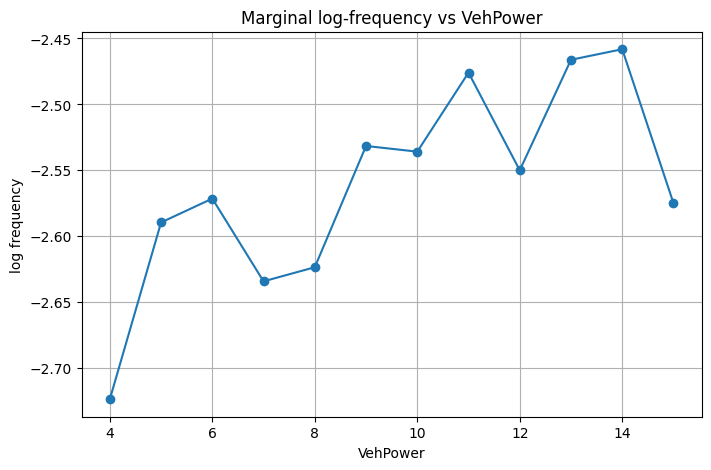

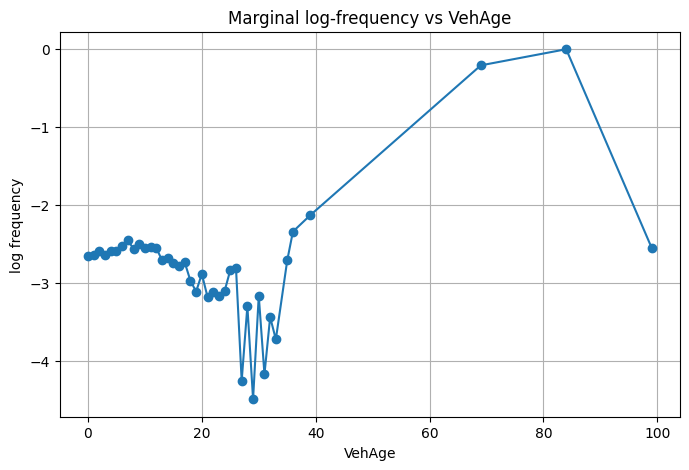

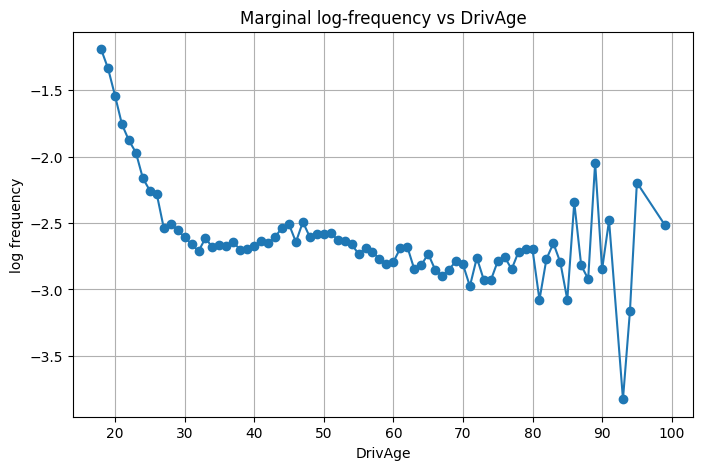

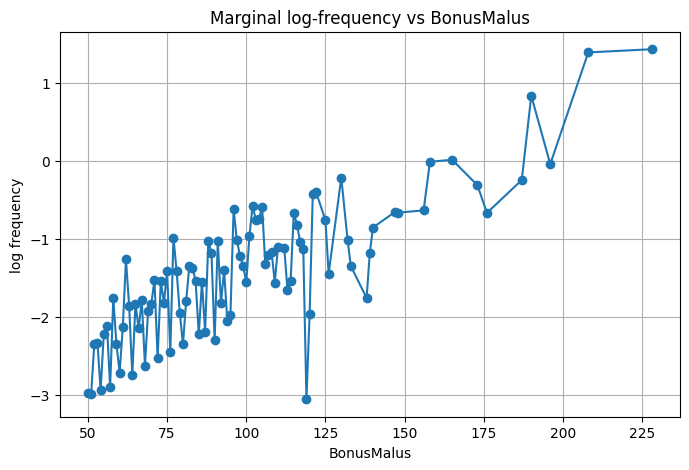

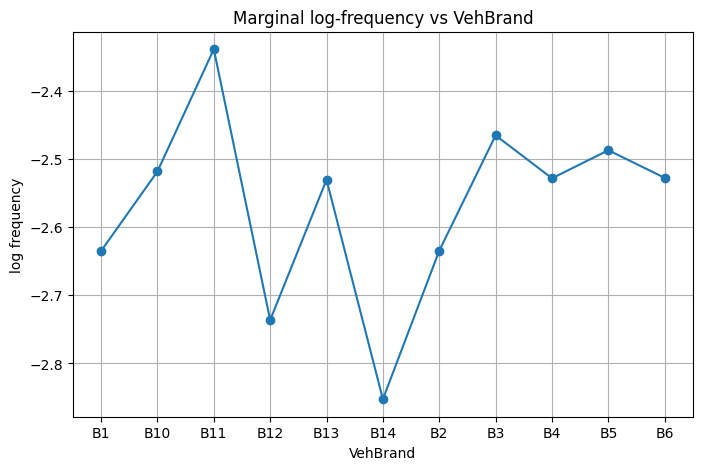

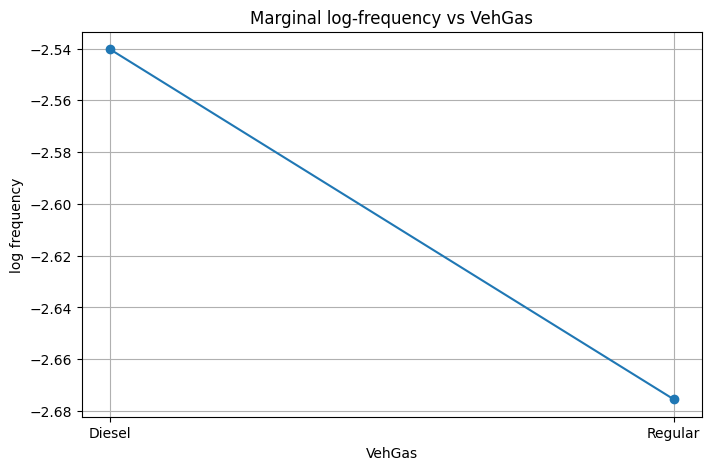

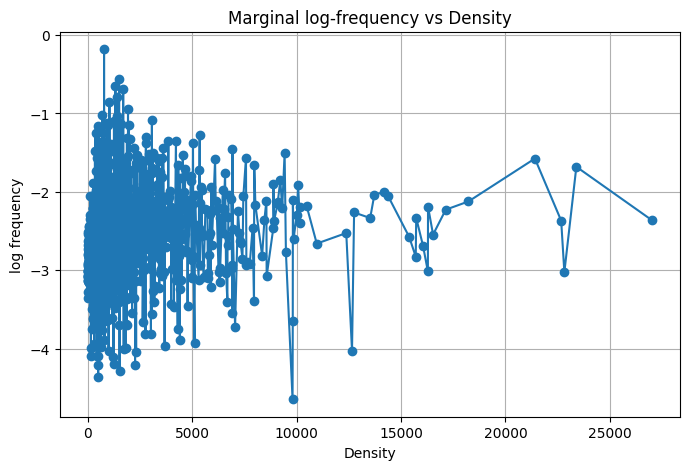

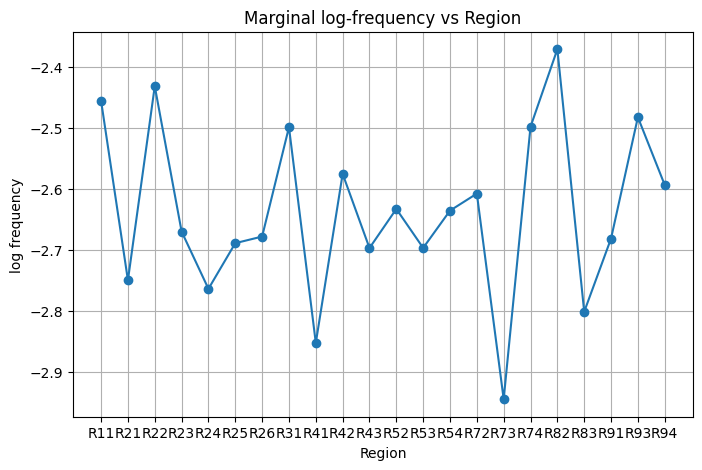

In [6]:
# Plot the empirical marginal log-frequencies
df = pd.concat([X_full, y_full], axis=1)
df = df[df["Exposure"] > 0]
features = X_full.columns

for feature in features:
    grouped = df.groupby(feature).agg({
        "ClaimNb": "sum",
        "Exposure": "sum"
    })

    # empirical frequency
    grouped["freq"] = grouped["ClaimNb"] / grouped["Exposure"]

    # remove zero-frequencies before log
    grouped = grouped[grouped["freq"] > 0]

    # log-frequency
    grouped["log_freq"] = np.log(grouped["freq"])

    # ---- Plot ----
    plt.figure(figsize=(8, 5))
    plt.plot(grouped.index, grouped["log_freq"], marker='o')
    plt.title(f"Marginal log-frequency vs {feature}")
    plt.xlabel(feature)
    plt.ylabel("log frequency")
    plt.grid(True)
    plt.show()

In [7]:
# Propose feature transformations. Justify your choices

### Question 1.c

In [8]:
# Train a Poisson GLM using your feature transformations

# Print MAE, MSE and loss on train and test data sets

# Make sure your model outperforms the model of Question 1.a

# Exercise 2 (Poisson FNN)

### Question 2.a

In [31]:
# Neural network implementation

# Poisson Neural Network: ReLU hidden layers + exponential output
class PoissonNN(torch.nn.Module):
    """
    Feedforward neural network for Poisson regression.
    Architecture: input -> dense(100, ReLU) -> dense(100, ReLU) -> output(exp)
    """
    def __init__(self, input_dim, output_dim):
        super(PoissonNN, self).__init__()
        self.encoder = torch.nn.Linear(input_dim, 400)
        self.batchnorm = torch.nn.BatchNorm1d(400)
        self.hidden_layer1 = torch.nn.Linear(400, 400)
        self.hidden_layer2 = torch.nn.Linear(400, 400)
        self.hidden_layer3 = torch.nn.Linear(400, 400)
        self.hidden_layer4 = torch.nn.Linear(400, 400)
        self.hidden_layer5 = torch.nn.Linear(400, 200)
        self.hidden_layer6 = torch.nn.Linear(200, 100)
        self.hidden_layer7 = torch.nn.Linear(100, 100)
        self.head = torch.nn.Linear(100, output_dim)
        self.relu = torch.nn.ReLU()
        self.tanh = torch.nn.Tanh()
    
    def forward(self, x):
        x = self.relu(self.encoder(x))
        x = self.batchnorm(x)
        x = self.relu(self.hidden_layer1(x))
        x = self.tanh(self.hidden_layer2(x))
        x = self.relu(self.hidden_layer3(x))
        x = self.tanh(self.hidden_layer4(x))
        x = self.relu(self.hidden_layer5(x))
        x = self.tanh(self.hidden_layer6(x))
        x = self.tanh(self.hidden_layer7(x))
        x = self.head(x)
        x = torch.exp(x)  # exponential activation on output
        return x

    # def __init__(self, input_dim, output_dim):
    #     super(PoissonNN, self).__init__()
    #     self.encoder = torch.nn.Linear(input_dim, 20)
    #     self.hidden_layer = torch.nn.Linear(20, 20)
    #     self.decoder = torch.nn.Linear(20, output_dim)
    #     self.relu = torch.nn.ReLU()
    # 
    # def forward(self, x):
    #     x = self.relu(self.encoder(x))
    #     # x = self.relu(self.hidden_layer(x))
    #     x = torch.exp(self.decoder(x))  # exponential activation on output
    #     return x


#Model instantiation (adapt N and M to data dimensions)
N = X_encoded.shape[1]  # number of input features
print(f"Number of input features: {N}")
M = 1                    # number of output targets (ClaimFrequency/Exposure)
test_model = PoissonNN(input_dim=N, output_dim=M)
print(f"PoissonNN model created with input_dim={N}, output_dim={M}")
print(f"\nPoissonNN architecture:\n{test_model}")

Number of input features: 40
PoissonNN model created with input_dim=40, output_dim=1

PoissonNN architecture:
PoissonNN(
  (encoder): Linear(in_features=40, out_features=400, bias=True)
  (batchnorm): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden_layer1): Linear(in_features=400, out_features=400, bias=True)
  (hidden_layer2): Linear(in_features=400, out_features=400, bias=True)
  (hidden_layer3): Linear(in_features=400, out_features=400, bias=True)
  (hidden_layer4): Linear(in_features=400, out_features=400, bias=True)
  (hidden_layer5): Linear(in_features=400, out_features=200, bias=True)
  (hidden_layer6): Linear(in_features=200, out_features=100, bias=True)
  (hidden_layer7): Linear(in_features=100, out_features=100, bias=True)
  (head): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
  (tanh): Tanh()
)


### Question 2.b

In [16]:
# Train Poisson feedforward neural network model

from tqdm import tqdm

# Detect GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

X_train_tensor = torch.tensor(X_train.to_numpy(dtype=np.float32))
X_test_tensor = torch.tensor(X_test.to_numpy(dtype=np.float32))
y_train_tensor = torch.tensor(y_train["ClaimFrequency"].to_numpy(dtype=np.float32).reshape(-1, 1))
y_test_tensor = torch.tensor(y_test["ClaimFrequency"].to_numpy(dtype=np.float32).reshape(-1, 1))
exposure_train_tensor = torch.tensor(y_train["Exposure"].to_numpy(dtype=np.float32))
exposure_test_tensor = torch.tensor(y_test["Exposure"].to_numpy(dtype=np.float32))

print(f'type of X_train_tensor: {type(X_train_tensor)}, shape: {X_train_tensor.shape}')

# ============================================
#   PREPARE DATA (dataset_train is TensorDataset)
# ============================================
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device).squeeze()
y_test_tensor = y_test_tensor.to(device).squeeze()
exposure_train_tensor = exposure_train_tensor.to(device)
exposure_test_tensor = exposure_test_tensor.to(device)



Using device: cuda

type of X_train_tensor: <class 'torch.Tensor'>, shape: torch.Size([610206, 40])


In [12]:

# ============================================
#   CUSTOM LOSS
# ============================================

def loss_fn(lam, y, exposure):
    # add tiny eps for numerical stability
    eps = 1e-8
    # term1 = y * log(lam), zero where lam==0
    term1 = torch.where(y > 0, y * torch.log(lam), torch.zeros_like(y))
    # term2 = y * log(y), zero where y==0
    term2 = torch.where(y > 0, y * torch.log(y), torch.zeros_like(y))

    # Poisson deviance
    dev = 2.0 * (lam - y - term1 + term2)

    # exposure-weighted mean
    loss = torch.sum(exposure * dev) / (torch.sum(exposure) + eps)
    return loss




In [13]:
class PoissonTrainer:
    def __init__(self, model, loss_fn=loss_fn, lr=1e-2, batch_size=10000, n_epochs=100, milestones=[], n = N):
        """
        Trainer for Poisson GLMs or neural networks using a custom loss.

        """
        # Detect device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"[INFO] Using device: {self.device}")

        # Store parameters
        self.model = model.to(self.device)
        self.loss_fn = loss_fn
        self.lr = lr
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.milestones = milestones
        self.n = n
        # the regularizaiton needs to be explicitly defined if elasticnet, else we just handle via l1/l2 lambda paremeters
        self.lam_1 = 0.0 # L1 regularizer
        self.lam_2 = 0.0 # L2 regularizer
        self.alpha = 0.0 # elastic net mixing parameter
        self.l1_ratio = 0.0 # l1 ratio for elastic net
        self.regularizer = None

        # Optimizer + scheduler
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=self.milestones, gamma=0.1)

        self.epoch_losses = []

    # ------------------------------------------------------------
    # TRAIN METHOD
    # ------------------------------------------------------------
    def train(self, X_train, y_train, exposure_train):
        self.model.train()
        self.epoch_losses = []

        loop = tqdm(range(self.n_epochs))
        for epoch in loop:
            perm = torch.randperm(self.n, device=self.device)
            total_loss_accum = 0.0

            for i in range(0, self.n, self.batch_size):
                idx = perm[i:i + self.batch_size]
                batch_X = X_train[idx]
                batch_y = y_train[idx]
                batch_exp = exposure_train[idx]

                lam = self.model(batch_X).squeeze()
                l1 = sum(p.abs().sum() for p in self.model.parameters())
                l2 = sum(p.square().sum() for p in self.model.parameters())
                if self.regularizer == 'elasticnet':
                    loss = self.loss_fn(lam, batch_y, batch_exp) + self.alpha * (self.l1_ratio * l1 + (1 - self.l1_ratio)/2 * l2)
                else:
                    loss = self.loss_fn(lam, batch_y, batch_exp) + self.lam_1 * l1 + self.lam_2 * l2

                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                total_loss_accum += loss.detach()

            self.epoch_losses.append(total_loss_accum.item())
            loop.set_postfix(loss=total_loss_accum)

            self.scheduler.step()

        print("\nTraining completed!\n")

    # ------------------------------------------------------------
    # EVALUATION METHOD
    # ------------------------------------------------------------
    def evaluate(self, X_train, y_train, exposure_train,
                       X_test, y_test, exposure_test, verbose=False):

        self.model.eval()
        with torch.no_grad():
            lam_train = self.model(X_train.to(self.device)).squeeze().cpu().numpy()
            lam_test  = self.model(X_test.to(self.device)).squeeze().cpu().numpy()

        y_train_np = y_train.cpu().numpy()
        y_test_np  = y_test.cpu().numpy()
        exp_train_np = exposure_train.cpu().numpy()
        exp_test_np  = exposure_test.cpu().numpy()

        # Poisson deviance using custom loss
        train_poi_dev = self.loss_fn(
            torch.tensor(lam_train),
            torch.tensor(y_train_np),
            torch.tensor(exp_train_np),
        ).item()

        test_poi_dev = self.loss_fn(
            torch.tensor(lam_test),
            torch.tensor(y_test_np),
            torch.tensor(exp_test_np),
        ).item()

        # ---- Metrics ----
        if verbose:
            print("=== TRAIN METRICS ===")
            print("MAE:", mean_absolute_error(y_train_np, lam_train, sample_weight=exp_train_np))
            print("MSE:", mean_squared_error(y_train_np, lam_train, sample_weight=exp_train_np))
            print("Exposure-weighted Poisson deviance (Sklearn):",
                mean_poisson_deviance(y_train_np, lam_train, sample_weight=exp_train_np))
            print("Exposure-weighted Poisson deviance (Torch custom):", train_poi_dev)

            print("\n=== TEST METRICS ===")
            print("MAE:", mean_absolute_error(y_test_np, lam_test, sample_weight=exp_test_np))
            print("MSE:", mean_squared_error(y_test_np, lam_test, sample_weight=exp_test_np))
            print("Exposure-weighted Poisson deviance (Sklearn):",
                mean_poisson_deviance(y_test_np, lam_test, sample_weight=exp_test_np))
            print("Exposure-weighted Poisson deviance (Torch custom):", test_poi_dev)

        return {
            "train": {
                "mae": mean_absolute_error(y_train_np, lam_train, sample_weight=exp_train_np),
                "mse": mean_squared_error(y_train_np, lam_train, sample_weight=exp_train_np),
                "dev_sklearn": mean_poisson_deviance(y_train_np, lam_train, sample_weight=exp_train_np),
                "dev_torch": train_poi_dev
            },
            "test": {
                "mae": mean_absolute_error(y_test_np, lam_test, sample_weight=exp_test_np),
                "mse": mean_squared_error(y_test_np, lam_test, sample_weight=exp_test_np),
                "dev_sklearn": mean_poisson_deviance(y_test_np, lam_test, sample_weight=exp_test_np),
                "dev_torch": test_poi_dev
            }
        }

    # ------------------------------------------------------------
    # LOSS-PLOT METHOD
    # ------------------------------------------------------------
    def plot_losses(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.epoch_losses, label="Exposure-weighted Poisson deviance")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss per Epoch")
        plt.grid(True)
        plt.legend()
        plt.show()

    # ------------------------------------------------------------
    # FREE GPU
    # ------------------------------------------------------------
    def free_gpu(self):
        self.model = self.model.to("cpu")
        torch.cuda.empty_cache()


[INFO] Using device: cuda


100%|██████████| 100/100 [00:01<00:00, 89.23it/s, loss=tensor(0.4440, device='cuda:0')]



Training completed!

=== TRAIN METRICS ===
MAE: 0.1542639285326004
MSE: 0.23741748929023743
Exposure-weighted Poisson deviance (Sklearn): 0.4810689091682434
Exposure-weighted Poisson deviance (Torch custom): 0.48106899857521057

=== TEST METRICS ===
MAE: 0.15228834748268127
MSE: 0.2571925222873688
Exposure-weighted Poisson deviance (Sklearn): 0.47336000204086304
Exposure-weighted Poisson deviance (Torch custom): 0.4733598828315735


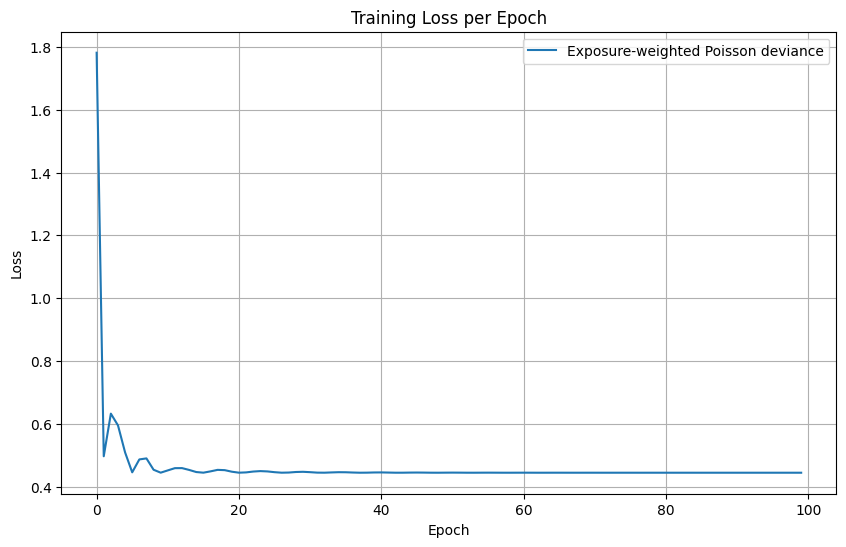

In [32]:
model = PoissonNN(input_dim=N, output_dim=M)
standardTrainer = PoissonTrainer(model=model, n_epochs=100, lr=1e-2)
standardTrainer.train(X_train_tensor, y_train_tensor, exposure_train_tensor)
standardTrainer.evaluate(X_train_tensor, y_train_tensor, exposure_train_tensor,
                         X_test_tensor, y_test_tensor, exposure_test_tensor, verbose=True)
standardTrainer.plot_losses()
 

[INFO] Using device: cuda


  0%|          | 0/200 [00:00<?, ?it/s, loss=tensor(1.6444, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
100%|██████████| 200/200 [00:01<00:00, 103.03it/s, loss=tensor(0.4440, device='cuda:0')]



Training completed!

=== TRAIN METRICS ===
MAE: 0.15475934743881226
MSE: 0.2374345064163208
Exposure-weighted Poisson deviance (Sklearn): 0.48125895857810974
Exposure-weighted Poisson deviance (Torch custom): 0.4812587797641754

=== TEST METRICS ===
MAE: 0.15278539061546326
MSE: 0.2572118937969208
Exposure-weighted Poisson deviance (Sklearn): 0.4735773801803589
Exposure-weighted Poisson deviance (Torch custom): 0.4735773503780365


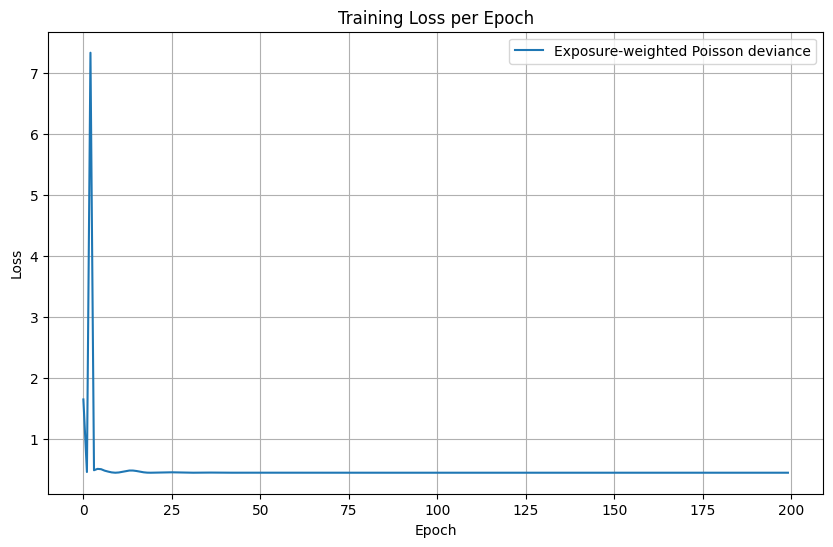

In [35]:
model = PoissonNN(input_dim=N, output_dim=M)
L2Trainer = PoissonTrainer(model=model, n_epochs=200, lr=1e-2)
L2Trainer.optimizer = torch.optim.AdamW(L2Trainer.model.parameters(), lr=L2Trainer.lr, weight_decay=0.1)
L2Trainer.train(X_train_tensor, y_train_tensor, exposure_train_tensor)
L2Trainer.evaluate(X_train_tensor, y_train_tensor, exposure_train_tensor,
                         X_test_tensor, y_test_tensor, exposure_test_tensor, verbose=True)
L2Trainer.plot_losses()

[INFO] Using device: cuda


100%|██████████| 100/100 [00:01<00:00, 93.31it/s, loss=tensor(110.9454, device='cuda:0')]



Training completed!

=== TRAIN METRICS ===
MAE: 0.2699359953403473
MSE: 0.2577027678489685
Exposure-weighted Poisson deviance (Sklearn): 0.6055322885513306
Exposure-weighted Poisson deviance (Torch custom): 0.605532169342041

=== TEST METRICS ===
MAE: 0.26835429668426514
MSE: 0.27805379033088684
Exposure-weighted Poisson deviance (Sklearn): 0.6018334627151489
Exposure-weighted Poisson deviance (Torch custom): 0.6018332242965698


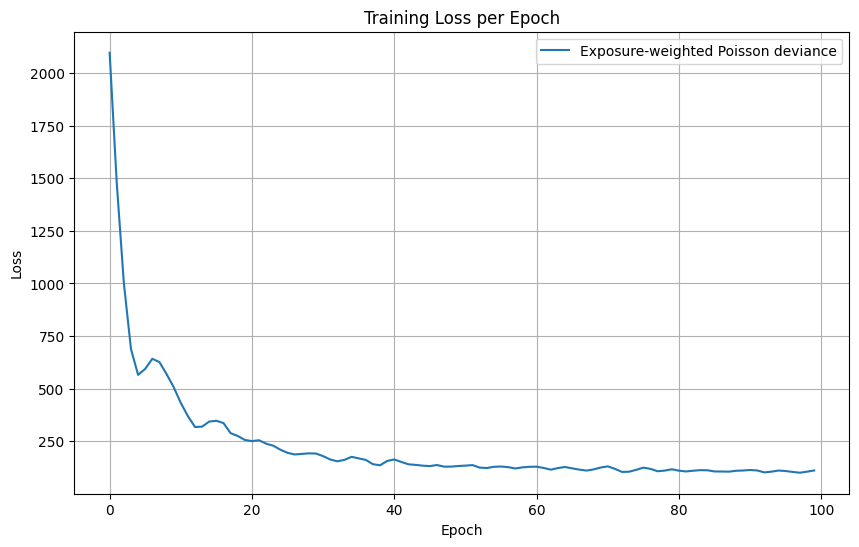

In [ ]:
 # L1 Test
model = PoissonNN(input_dim=N, output_dim=M)
L1Trainer = PoissonTrainer(model=model, n_epochs=300, lr=1e-2)
L1Trainer.lam_1 = 0.01  # Set L1 regularization parameter
L1Trainer.train(X_train_tensor, y_train_tensor, exposure_train_tensor)
L1Trainer.evaluate(X_train_tensor, y_train_tensor, exposure_train_tensor,
                         X_test_tensor, y_test_tensor, exposure_test_tensor, verbose=True)
L1Trainer.plot_losses()

[INFO] Using device: cuda


100%|██████████| 100/100 [00:01<00:00, 91.42it/s, loss=tensor(8.2403, device='cuda:0')] 



Training completed!

=== TRAIN METRICS ===
MAE: 0.2184072881937027
MSE: 0.2446155995130539
Exposure-weighted Poisson deviance (Sklearn): 0.5364707708358765
Exposure-weighted Poisson deviance (Torch custom): 0.536470890045166

=== TEST METRICS ===
MAE: 0.21665020287036896
MSE: 0.26471003890037537
Exposure-weighted Poisson deviance (Sklearn): 0.5314004421234131
Exposure-weighted Poisson deviance (Torch custom): 0.5314003825187683


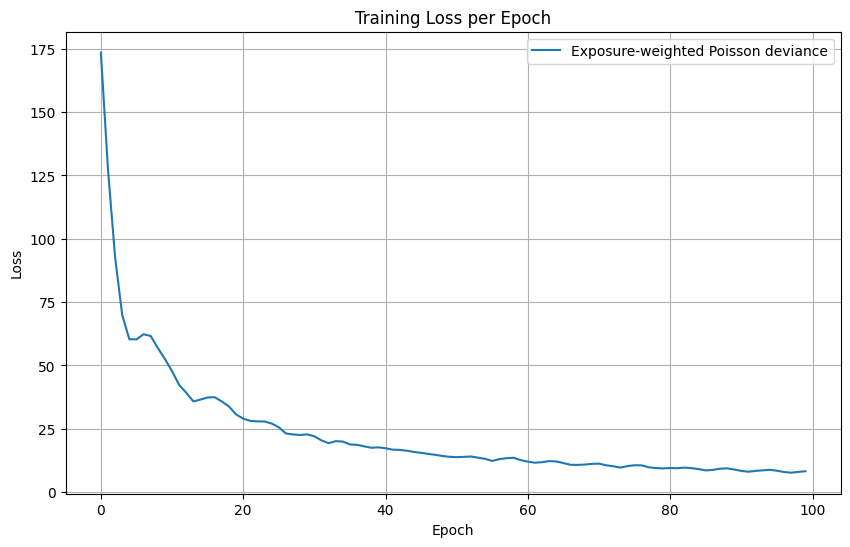

In [29]:
#elasticnet test
model = PoissonNN(input_dim=N, output_dim=M)
elastictrainer = PoissonTrainer(model=model)
elastictrainer.regularizer = 'elasticnet'
elastictrainer.alpha = 0.1
elastictrainer.l1_ratio = 0.1  # Set l1 ratio for elastic net
elastictrainer.train(X_train_tensor, y_train_tensor, exposure_train_tensor)
elastictrainer.evaluate(X_train_tensor, y_train_tensor, exposure_train_tensor,
                         X_test_tensor, y_test_tensor, exposure_test_tensor, verbose=True)
elastictrainer.plot_losses()

In [29]:
# Example weight_decay values to test for L2
weight_decays = [0.001, 0.01, 0.1, 1.0, 5.0, 10.0]
# L1 Regularizers to test
l1_values = [0.001, 0.01, 0.1, 1.0, 5.0, 10.0]
# Number of folds
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store results for each weight_decay
cv_results_l2 = {}
cv_results_l1 = {}

# Convert tensors to numpy for indexing
X_np = X_train_tensor.cpu().numpy()
y_np = y_train_tensor.cpu().numpy()
exp_np = exposure_train_tensor.cpu().numpy()

for l1_val, wd in zip(l1_values, weight_decays):
    print(f"\n=== Testing weight_decay={wd} === and l1 regularizer={l1_val} ===")
    
    fold_metrics_l2 = []
    fold_metrics_l1 = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_np)):
        print(f"\n--- Fold {fold+1}/{n_splits} ---")
        
        # Create fold tensors
        X_train_fold = torch.tensor(X_np[train_idx], dtype=X_train_tensor.dtype, device=DEVICE)
        y_train_fold = torch.tensor(y_np[train_idx], dtype=y_train_tensor.dtype, device=DEVICE)
        exp_train_fold = torch.tensor(exp_np[train_idx], dtype=exposure_train_tensor.dtype, device=DEVICE)
        
        X_val_fold = torch.tensor(X_np[val_idx], dtype=X_train_tensor.dtype, device=DEVICE)
        y_val_fold = torch.tensor(y_np[val_idx], dtype=y_train_tensor.dtype, device=DEVICE)
        exp_val_fold = torch.tensor(exp_np[val_idx], dtype=exposure_train_tensor.dtype, device=DEVICE)
        
        # Create new model for each fold and regularizer
        model_l2 = PoissonNN(input_dim=N, output_dim=M)
        model_l1 = PoissonNN(input_dim=N, output_dim=M)
        # Create trainer
        trainer_l2 = PoissonTrainer(model=model_l2)
        # Set optimizer with weight_decay
        trainer_l2.optimizer = torch.optim.AdamW(
            trainer_l2.model.parameters(),
            lr=trainer_l2.lr,
            weight_decay=wd
        )
        trainer_l1 = PoissonTrainer(model=model_l1)
        trainer_l1.lam_1 = l1_val
        # Train
        trainer_l2.train(X_train_fold, y_train_fold, exp_train_fold)
        trainer_l1.train(X_train_fold, y_train_fold, exp_train_fold)
        
        # Evaluate on validation fold
        metrics_l2 = trainer_l2.evaluate(
            X_train_fold, y_train_fold, exp_train_fold,
            X_val_fold, y_val_fold, exp_val_fold
        )
        # Evaluate on validation fold
        metrics_l1 = trainer_l1.evaluate(
            X_train_fold, y_train_fold, exp_train_fold,
            X_val_fold, y_val_fold, exp_val_fold
        )
        
        fold_metrics_l2.append(metrics_l2['test'])  # store test (validation) metrics
        fold_metrics_l1.append(metrics_l1['test'])  # store test (validation) metrics
        
        # Free GPU
        # trainer.free_gpu()
    
    # Average metrics across folds
    avg_metrics_l2 = {
        "mae": np.mean([m['mae'] for m in fold_metrics_l2]),
        "mse": np.mean([m['mse'] for m in fold_metrics_l2]),
        "dev_sklearn": np.mean([m['dev_sklearn'] for m in fold_metrics_l2]),
        "dev_torch": np.mean([m['dev_torch'] for m in fold_metrics_l2])
    }

       # Average metrics across folds
    avg_metrics_l1 = {
        "mae": np.mean([m['mae'] for m in fold_metrics_l1]),
        "mse": np.mean([m['mse'] for m in fold_metrics_l1]),
        "dev_sklearn": np.mean([m['dev_sklearn'] for m in fold_metrics_l1]),
        "dev_torch": np.mean([m['dev_torch'] for m in fold_metrics_l1])
    }
    
    cv_results_l2[wd] = avg_metrics_l2
    cv_results_l1[l1_val] = avg_metrics_l1
    # print(f"\nAverage metrics for weight_decay={wd}: {avg_metrics_l2}")

print("\n=== Cross-validation complete ===")



=== Testing weight_decay=0.001 === and l1 regularizer=0.001 ===

--- Fold 1/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.5210, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.5210, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!



100%|██████████| 100/100 [00:00<00:00, 215.93it/s, loss=tensor(0.1227, device='cuda:0')]




Training completed!


--- Fold 2/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.8295, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.8295, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!



100%|██████████| 100/100 [00:00<00:00, 211.03it/s, loss=tensor(0.1341, device='cuda:0')]




Training completed!


--- Fold 3/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.6186, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.6186, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!



100%|██████████| 100/100 [00:00<00:00, 210.43it/s, loss=tensor(0.1269, device='cuda:0')]




Training completed!


--- Fold 4/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.7673, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.7673, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!



100%|██████████| 100/100 [00:00<00:00, 209.84it/s, loss=tensor(0.1346, device='cuda:0')]




Training completed!


--- Fold 5/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.3059, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.3059, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!



100%|██████████| 100/100 [00:00<00:00, 216.15it/s, loss=tensor(0.1391, device='cuda:0')]




Training completed!


=== Testing weight_decay=0.01 === and l1 regularizer=0.01 ===

--- Fold 1/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.7545, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.7545, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!



100%|██████████| 100/100 [00:00<00:00, 214.08it/s, loss=tensor(0.4634, device='cuda:0')]




Training completed!


--- Fold 2/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.9037, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.9037, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!



100%|██████████| 100/100 [00:00<00:00, 207.05it/s, loss=tensor(0.5063, device='cuda:0')]




Training completed!


--- Fold 3/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.7124, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.7124, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!



100%|██████████| 100/100 [00:00<00:00, 209.74it/s, loss=tensor(0.4785, device='cuda:0')]




Training completed!


--- Fold 4/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.6727, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.6727, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!



100%|██████████| 100/100 [00:00<00:00, 210.87it/s, loss=tensor(0.5218, device='cuda:0')]




Training completed!


--- Fold 5/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.5852, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.5852, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!



100%|██████████| 100/100 [00:01<00:00, 58.69it/s, loss=tensor(0.4873, device='cuda:0')]




Training completed!


=== Testing weight_decay=0.1 === and l1 regularizer=0.1 ===

--- Fold 1/5 ---

=== Testing weight_decay=0.1 === and l1 regularizer=0.1 ===

--- Fold 1/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda
[INFO] Using device: cuda
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.3458, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.2164, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!



100%|██████████| 100/100 [00:02<00:00, 38.54it/s, loss=tensor(1.0240, device='cuda:0')]




Training completed!


--- Fold 2/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda

--- Fold 2/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.3280, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.1486, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!



100%|██████████| 100/100 [00:02<00:00, 37.80it/s, loss=tensor(1.1656, device='cuda:0')]




Training completed!


--- Fold 3/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda

--- Fold 3/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.4759, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.4759, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!



100%|██████████| 100/100 [00:02<00:00, 35.48it/s, loss=tensor(1.1327, device='cuda:0')]




Training completed!


--- Fold 4/5 ---

--- Fold 4/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda
[INFO] Using device: cuda
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.7424, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.7424, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!



100%|██████████| 100/100 [00:02<00:00, 36.37it/s, loss=tensor(1.0227, device='cuda:0')]




Training completed!


--- Fold 5/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda

--- Fold 5/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.1198, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.1198, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!



100%|██████████| 100/100 [00:02<00:00, 35.82it/s, loss=tensor(1.0115, device='cuda:0')]




Training completed!


=== Testing weight_decay=1.0 === and l1 regularizer=1.0 ===

--- Fold 1/5 ---

=== Testing weight_decay=1.0 === and l1 regularizer=1.0 ===

--- Fold 1/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda
[INFO] Using device: cuda
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.4486, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.4486, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!



100%|██████████| 100/100 [00:02<00:00, 35.52it/s, loss=tensor(1.7512, device='cuda:0')]




Training completed!


--- Fold 2/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda

--- Fold 2/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.6971, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.6971, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!



100%|██████████| 100/100 [00:02<00:00, 35.01it/s, loss=tensor(1.6999, device='cuda:0')]




Training completed!


--- Fold 3/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda

--- Fold 3/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.9260, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.9260, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!



100%|██████████| 100/100 [00:02<00:00, 37.49it/s, loss=tensor(1.7352, device='cuda:0')]




Training completed!


--- Fold 4/5 ---

--- Fold 4/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda
[INFO] Using device: cuda
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.0983, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.0983, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!



100%|██████████| 100/100 [00:02<00:00, 37.07it/s, loss=tensor(1.7059, device='cuda:0')]




Training completed!


--- Fold 5/5 ---

--- Fold 5/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda
[INFO] Using device: cuda
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.7735, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  4%|▍         | 4/100 [00:00<00:02, 37.71it/s, loss=tensor(1.3767, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTor


Training completed!



100%|██████████| 100/100 [00:02<00:00, 35.91it/s, loss=tensor(1.8191, device='cuda:0')]




Training completed!


=== Testing weight_decay=5.0 === and l1 regularizer=5.0 ===

--- Fold 1/5 ---

=== Testing weight_decay=5.0 === and l1 regularizer=5.0 ===

--- Fold 1/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda
[INFO] Using device: cuda
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.1282, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.1282, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!



100%|██████████| 100/100 [00:02<00:00, 36.79it/s, loss=tensor(2.2100, device='cuda:0')] 




Training completed!


--- Fold 2/5 ---

--- Fold 2/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda
[INFO] Using device: cuda
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.7882, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.7882, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!



100%|██████████| 100/100 [00:02<00:00, 35.78it/s, loss=tensor(2.1395, device='cuda:0')] 




Training completed!


--- Fold 3/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda

--- Fold 3/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.2681, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.6263, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!



100%|██████████| 100/100 [00:02<00:00, 36.54it/s, loss=tensor(2.2198, device='cuda:0')] 




Training completed!


--- Fold 4/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda

--- Fold 4/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.9477, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  5%|▌         | 5/100 [00:00<00:02, 43.10it/s, loss=tensor(1.5431, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTor


Training completed!



100%|██████████| 100/100 [00:02<00:00, 37.28it/s, loss=tensor(2.1918, device='cuda:0')] 




Training completed!


--- Fold 5/5 ---

--- Fold 5/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda
[INFO] Using device: cuda
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.5131, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.3330, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!



100%|██████████| 100/100 [00:02<00:00, 37.46it/s, loss=tensor(2.1329, device='cuda:0')] 




Training completed!


=== Testing weight_decay=10.0 === and l1 regularizer=10.0 ===

--- Fold 1/5 ---

=== Testing weight_decay=10.0 === and l1 regularizer=10.0 ===

--- Fold 1/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda
[INFO] Using device: cuda
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.2498, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.9840, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!



100%|██████████| 100/100 [00:02<00:00, 38.43it/s, loss=tensor(2.4766, device='cuda:0')]



Training completed!


--- Fold 2/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda

--- Fold 2/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.0840, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.0840, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!



100%|██████████| 100/100 [00:02<00:00, 35.47it/s, loss=tensor(2.4173, device='cuda:0')] 




Training completed!


--- Fold 3/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda

--- Fold 3/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.9274, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.7481, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!



100%|██████████| 100/100 [00:02<00:00, 36.33it/s, loss=tensor(2.4890, device='cuda:0')] 




Training completed!


--- Fold 4/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda

--- Fold 4/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.0457, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.6892, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!



100%|██████████| 100/100 [00:02<00:00, 35.53it/s, loss=tensor(2.4861, device='cuda:0')] 




Training completed!


--- Fold 5/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda

--- Fold 5/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.1993, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.8902, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!



100%|██████████| 100/100 [00:00<00:00, 199.62it/s, loss=tensor(2.4241, device='cuda:0')] 




Training completed!


=== Cross-validation complete ===


In [30]:


# Display all cross-validation results
print("\n" + "="*60)
print("CROSS-VALIDATION RESULTS - ALL WEIGHT_DECAY VALUES")
print("="*60)

for wd, metrics in cv_results_l2.items():
    print(f"\nweight_decay = {wd}:")
    print(f"  {metrics}")

for l1_val, metrics in cv_results_l1.items():
    print(f"\nlasso regularizer = {l1_val}:")
    print(f"  {metrics}")




CROSS-VALIDATION RESULTS - ALL WEIGHT_DECAY VALUES

weight_decay = 0.001:
  {'mae': np.float64(0.07909282594919205), 'mse': np.float64(0.24296275079250335), 'dev_sklearn': np.float64(1.5763689994812011), 'dev_torch': np.float64(1.5763690233230592)}

weight_decay = 0.01:
  {'mae': np.float64(0.07927955836057662), 'mse': np.float64(0.24308348596096038), 'dev_sklearn': np.float64(1.4413203001022339), 'dev_torch': np.float64(1.4413203001022339)}

weight_decay = 0.1:
  {'mae': np.float64(0.07899602502584457), 'mse': np.float64(0.24238864481449127), 'dev_sklearn': np.float64(1.1254351139068604), 'dev_torch': np.float64(1.1254350900650025)}

weight_decay = 1.0:
  {'mae': np.float64(0.0832645982503891), 'mse': np.float64(0.24188654124736786), 'dev_sklearn': np.float64(0.847322416305542), 'dev_torch': np.float64(0.847322416305542)}

weight_decay = 5.0:
  {'mae': np.float64(0.15943835079669952), 'mse': np.float64(0.24516337513923644), 'dev_sklearn': np.float64(0.5115100085735321), 'dev_torch': 

In [ ]:
# cross validate elasticnet

from itertools import product
import numpy as np
import torch
from sklearn.model_selection import KFold

# Elastic Net hyperparameter grid
alphas = [0.001, 0.01, 0.1, 1.0, 5.0, 10.0]
l1_ratios = [0.1, 0.5, 0.75, 0.875, 1.0]  # 0=L2, 1=L1

# CV setup
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Storage
cv_results_elasticnet = {}

# Convert tensors to numpy for indexing
X_np = X_train_tensor.cpu().numpy()
y_np = y_train_tensor.cpu().numpy()
exp_np = exposure_train_tensor.cpu().numpy()

for alpha, l1_ratio in product(alphas, l1_ratios):

    print(f"\n=== Elastic Net: alpha={alpha}, l1_ratio={l1_ratio} ")

    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_np)):
        print(f"--- Fold {fold+1}/{n_splits} ---")

        # Fold tensors
        X_train_fold = torch.tensor(X_np[train_idx], dtype=X_train_tensor.dtype, device=DEVICE)
        y_train_fold = torch.tensor(y_np[train_idx], dtype=y_train_tensor.dtype, device=DEVICE)
        exp_train_fold = torch.tensor(exp_np[train_idx], dtype=exposure_train_tensor.dtype, device=DEVICE)

        X_val_fold = torch.tensor(X_np[val_idx], dtype=X_train_tensor.dtype, device=DEVICE)
        y_val_fold = torch.tensor(y_np[val_idx], dtype=y_train_tensor.dtype, device=DEVICE)
        exp_val_fold = torch.tensor(exp_np[val_idx], dtype=exposure_train_tensor.dtype, device=DEVICE)

        # Model + Trainer
        model = PoissonNN(input_dim=N, output_dim=M)
        trainer = PoissonTrainer(model=model)
        trainer.regularizer = 'elasticnet'
        trainer.alpha = alpha
        trainer.l1_ratio = l1_ratio

        # Train
        trainer.train(X_train_fold, y_train_fold, exp_train_fold)

        # Validate
        metrics = trainer.evaluate(
            X_train_fold, y_train_fold, exp_train_fold,
            X_val_fold, y_val_fold, exp_val_fold
        )

        fold_metrics.append(metrics['test'])

    # Average across folds
    avg_metrics = {
        "mae": np.mean([m['mae'] for m in fold_metrics]),
        "mse": np.mean([m['mse'] for m in fold_metrics]),
        "dev_sklearn": np.mean([m['dev_sklearn'] for m in fold_metrics]),
        "dev_torch": np.mean([m['dev_torch'] for m in fold_metrics]),
    }

    cv_results_elasticnet[(alpha, l1_ratio)] = avg_metrics

print("\n=== Elastic Net Grid Search Complete ===")


In [28]:
print("\nElastic Net CV Results")
print("-" * 70)
print(f"{'alpha':>8} {'l1_ratio':>10} {'MAE':>10} {'MSE':>10} {'Dev(SKL)':>12} {'Dev(Torch)':>12}")
print("-" * 70)

for (alpha, l1_ratio), m in cv_results_elasticnet.items():
    print(
        f"{alpha:8.4f} "
        f"{l1_ratio:10.2f} "
        f"{m['mae']:10.4f} "
        f"{m['mse']:10.4f} "
        f"{m['dev_sklearn']:12.4f} "
        f"{m['dev_torch']:12.4f}"
    )

print("-" * 70)



Elastic Net CV Results
----------------------------------------------------------------------
   alpha   l1_ratio        MAE        MSE     Dev(SKL)   Dev(Torch)
----------------------------------------------------------------------
  0.0010       0.10     0.0846     0.2418       0.9205       0.9205
  0.0010       0.50     0.0883     0.2414       0.8153       0.8153
  0.0010       0.75     0.0909     0.2414       0.8063       0.8063
  0.0010       0.88     0.0890     0.2409       0.7784       0.7784
  0.0010       1.00     0.0880     0.2419       0.8662       0.8662
  0.0100       0.10     0.0953     0.2411       0.7084       0.7084
  0.0100       0.50     0.1111     0.2408       0.5953       0.5953
  0.0100       0.75     0.1135     0.2399       0.5673       0.5673
  0.0100       0.88     0.1215     0.2405       0.5507       0.5507
  0.0100       1.00     0.1241     0.2405       0.5466       0.5466
  0.1000       0.10     0.1678     0.2408       0.4960       0.4960
  0.1000       0.5

# Exercise 3 (Tree-based methods)

### Question 3.a

In [ ]:
# Implement a regression tree

# Cross-validation

# Print MAE, MSE and loss on train and test data sets

### Question 3.b

In [ ]:
# Implement a random forest model

# Cross-validation

# Print MAE, MSE and loss on train and test data sets

### Question 3.c

In [ ]:
# Implement gradient boosted trees

# Cross-validation

# Print MAE, MSE and loss on train and test data sets